In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------------------------
# Fixed parameters
# ---------------------------

pullers = 672
uptime = 0.90
ingots_per_cycle = 5
hours_per_year = 8760

usable_length = 2908  # use improved length
kerf = 0.045  # improved kerf
brick_yield = 1 - 0.044
wafer_yield = 0.95
cycle_time = 281  # improved cycle time
power_per_half_wafer = 5.09

# ---------------------------
# Model functions
# ---------------------------

def ingots_per_puller(yield_puller):
    effective_hours = hours_per_year * uptime
    cycles_per_year = effective_hours / cycle_time
    return cycles_per_year * ingots_per_cycle * yield_puller

def wafers_per_ingot(thickness):
    raw_wafers = usable_length / (thickness + kerf)
    after_brick = raw_wafers * brick_yield
    usable_wafers = after_brick * wafer_yield
    return usable_wafers

def capacity_gw(yield_puller, thickness):
    ingots = ingots_per_puller(yield_puller)
    wafers = wafers_per_ingot(thickness)
    total_wafers = ingots * pullers * wafers
    half_wafers = total_wafers * 2
    total_power = half_wafers * power_per_half_wafer
    return total_power / 1e9


In [2]:
# ---------------------------
# Sensitivity ranges
# ---------------------------

yield_range = np.linspace(0.89, 0.94, 40)       # 89% to 94%
thickness_range = np.linspace(0.100, 0.140, 40) # 100 µm to 140 µm (in mm)

Y, T = np.meshgrid(yield_range, thickness_range)

# ---------------------------
# Compute capacity surface
# ---------------------------

capacity_surface = np.zeros_like(Y)

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        capacity_surface[i, j] = capacity_gw(Y[i, j], T[i, j])

print("Surface computed.")


Surface computed.


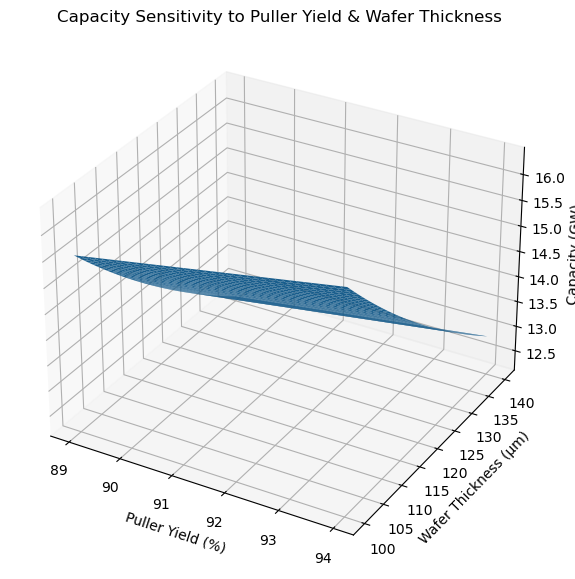

In [12]:
# ---------------------------
# 3D Surface Plot
# ---------------------------

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Y * 100,           # convert yield to %
    T * 1000,          # convert mm to µm
    capacity_surface,
)

ax.set_xlabel("Puller Yield (%)")
ax.set_ylabel("Wafer Thickness (µm)")
ax.set_zlabel("Capacity (GW)")

ax.set_title("Capacity Sensitivity to Puller Yield & Wafer Thickness")

plt.savefig("capacity_surface.png", dpi=300, bbox_inches="tight")
plt.show()



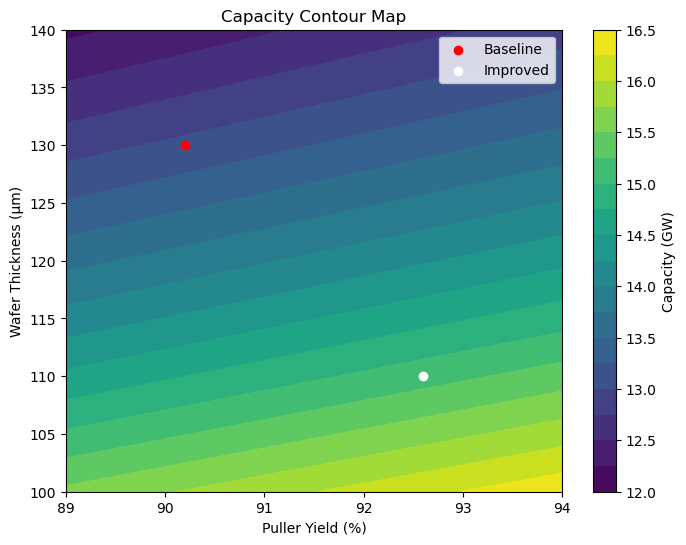

In [13]:
plt.figure(figsize=(8,6))

contour = plt.contourf(
    Y * 100,
    T * 1000,
    capacity_surface,
    levels=20
)

plt.xlabel("Puller Yield (%)")
plt.ylabel("Wafer Thickness (µm)")
plt.title("Capacity Contour Map")

plt.colorbar(label="Capacity (GW)")

plt.scatter(90.2, 130, color='red', label="Baseline")
plt.scatter(92.6, 110, color='white', label="Improved")

plt.legend()
plt.savefig("contour_plot.png", dpi=300, bbox_inches="tight")
plt.show()



## Sensitivity Surface – Strategic Interpretation

The 3D surface and contour map demonstrate that manufacturing capacity
is a nonlinear function of puller yield and wafer thickness.

Key Insights:

1. Wafer thickness reduction provides strong nonlinear amplification.
   Small reductions near 110 µm significantly increase capacity.

2. Puller yield acts as a multiplicative scaling factor.
   Even ±1% variation materially impacts plant-level output.

3. The improved operating point (92.6% yield, 110 µm thickness)
   lies in a high-capacity region of the surface.

4. Capacity risk exists if yield drops below 91% while thickness
   remains aggressive (<115 µm).

Strategic Conclusion:
Process optimization acts as a capital-equivalent lever.
Upstream yield and wafer improvements can unlock
> $100M+ capex avoidance and > ₹190 Cr annual utility savings,
without additional physical expansion.


In [5]:
# ---------------------------
# Monte Carlo Simulation
# ---------------------------

np.random.seed(42)

simulations = 10000

# Sample uncertain variables
yield_samples = np.random.normal(0.926, 0.008, simulations)
cycle_samples = np.random.normal(281, 5, simulations)
thickness_samples = np.random.normal(0.110, 0.005, simulations)

# Capacity simulation function (redefined to include cycle uncertainty)
def capacity_sim(yield_puller, cycle_time, thickness):
    effective_hours = hours_per_year * uptime
    cycles_per_year = effective_hours / cycle_time
    ingots = cycles_per_year * ingots_per_cycle * yield_puller
    wafers = wafers_per_ingot(thickness)
    total_wafers = ingots * pullers * wafers
    half_wafers = total_wafers * 2
    total_power = half_wafers * power_per_half_wafer
    return total_power / 1e9

# Run simulation
capacity_results = np.zeros(simulations)

for i in range(simulations):
    capacity_results[i] = capacity_sim(
        yield_samples[i],
        cycle_samples[i],
        thickness_samples[i]
    )

print("Monte Carlo simulation complete.")


Monte Carlo simulation complete.


In [6]:
# ---------------------------
# Distribution Summary
# ---------------------------

mean_capacity = np.mean(capacity_results)
std_capacity = np.std(capacity_results)

p5 = np.percentile(capacity_results, 5)
p50 = np.percentile(capacity_results, 50)
p95 = np.percentile(capacity_results, 95)

print("Mean Capacity (GW):", round(mean_capacity, 2))
print("Std Dev (GW):", round(std_capacity, 2))
print("5th Percentile (GW):", round(p5, 2))
print("Median (GW):", round(p50, 2))
print("95th Percentile (GW):", round(p95, 2))


Mean Capacity (GW): 15.16
Std Dev (GW): 0.58
5th Percentile (GW): 14.24
Median (GW): 15.15
95th Percentile (GW): 16.12


In [7]:
# ---------------------------
# Risk of Missing Target
# ---------------------------

target_capacity = 15  # GW

prob_below_target = np.mean(capacity_results < target_capacity)

print("Probability capacity < 15 GW:",
      round(prob_below_target * 100, 2), "%")


Probability capacity < 15 GW: 39.62 %


In [8]:
# Required deterministic capacity to achieve 95% reliability

required_for_95 = p95  # 95th percentile

print("Deterministic capacity needed for 95% confidence:",
      round(required_for_95, 2), "GW")


Deterministic capacity needed for 95% confidence: 16.12 GW


In [9]:
buffer_needed = 15 - p5
print("Buffer required above 15 GW for 95% confidence:",
      round(buffer_needed, 2), "GW")


Buffer required above 15 GW for 95% confidence: 0.76 GW


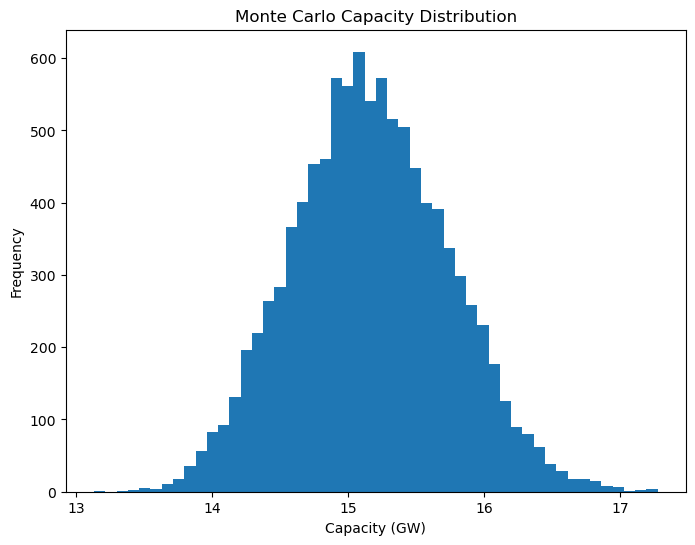

In [14]:
plt.figure(figsize=(8,6))
plt.hist(capacity_results, bins=50)
plt.xlabel("Capacity (GW)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Capacity Distribution")
plt.savefig("monte_carlo_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


## Risk-Adjusted Capacity Insight

Monte Carlo simulation reveals:

• Mean capacity: ~15.16 GW  
• 5th percentile capacity: ~14.24 GW  
• Probability of capacity < 15 GW: ~40%  

To achieve ≥15 GW with 95% confidence,
a deterministic design capacity of ~15.76 GW is required.

Strategic Conclusion:
Yield and thickness improvements unlock large capital savings,
but reliable production requires risk-adjusted engineering margins.
